# Field Validation

In [1]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [2]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
df.head()

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [3]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape
#Reshape data for LSTM (add time step dimension)
test_data_scaled_normal = test_data_scaled_normal.values.reshape(test_data_scaled_normal.shape[0], 1, test_data_scaled_normal.shape[1])
test_data_scaled_abnormal = test_data_scaled_abnormal.values.reshape(test_data_scaled_abnormal.shape[0], 1, test_data_scaled_abnormal.shape[1])
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape


((2427, 1, 100), (259, 1, 100))

In [4]:
# Make predictions using lstm utoencoder
lstm = tf.keras.models.load_model('../../models/lstm_autoencoder_best.keras')
with open('../../models/lstm_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


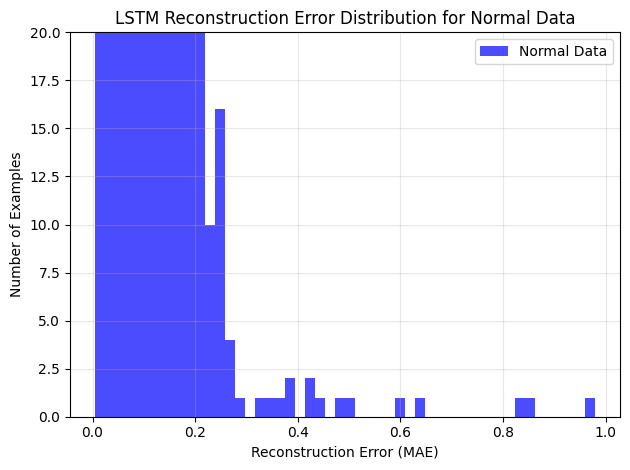

In [5]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = lstm.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.hist(train_loss_normal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Normal Data')

plt.title('LSTM Reconstruction Error Distribution for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0,20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


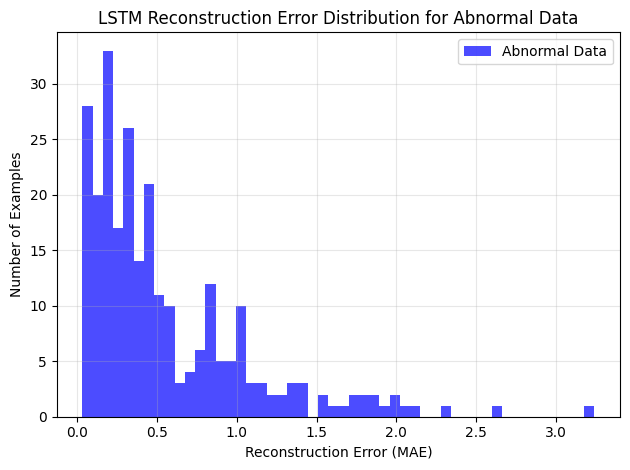

Mean reconstruction error: 0.0332
Median reconstruction error: 0.3819
Standard deviation: 0.5184


In [6]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = lstm.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Abnormal Data')

plt.title('LSTM Reconstruction Error Distribution for Abnormal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean reconstruction error: {np.min(train_loss_abnormal):.4f}")
print(f"Median reconstruction error: {np.median(train_loss_abnormal):.4f}")
print(f"Standard deviation: {np.std(train_loss_abnormal):.4f}")


--- Using Low Threshold: 0.197000 ---


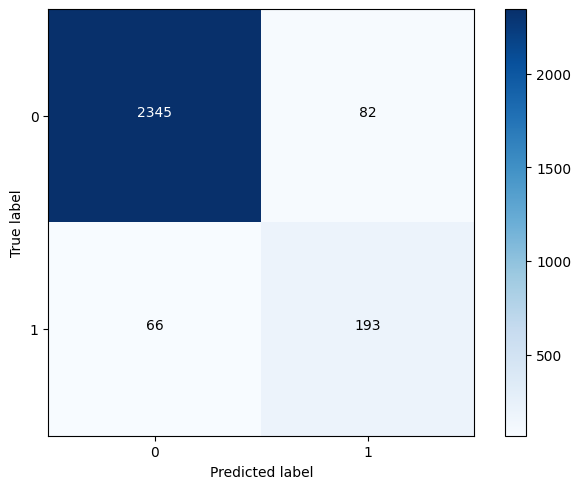


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2427
           1       0.70      0.75      0.72       259

    accuracy                           0.94      2686
   macro avg       0.84      0.86      0.85      2686
weighted avg       0.95      0.94      0.95      2686

Accuracy: 0.9449
Precision: 0.7018
Recall: 0.7452
F1 Score: 0.7228


In [7]:
# Function to create and display confusion matrix for a given threshold
def create_confusion_matrix(threshold, threshold_name):
    print(f"\n--- Using {threshold_name}: {threshold:.6f} ---")
    
    # Prepare the true labels and predictions
    true_labels = []
    predictions = []
    
    # Normal data (label 0)
    # Flatten the MAE values since LSTM outputs have an extra dimension
    normal_predictions = (train_loss_normal.numpy().flatten() > threshold).astype(int)
    true_labels.extend([0] * len(normal_predictions))
    predictions.extend(normal_predictions)
    
    # Abnormal data (label 1)
    abnormal_predictions = (train_loss_abnormal.numpy().flatten() > threshold).astype(int)
    true_labels.extend([1] * len(abnormal_predictions))
    predictions.extend(abnormal_predictions)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Label the plot
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))
    
    # Calculate and display metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }

# Generate confusion matrices for all thresholds
results = {}

# Check which threshold keys are available in your JSON
if 'low_threshold' in loaded_thresholds:
    results['low'] = create_confusion_matrix(loaded_thresholds['low_threshold'], 'Low Threshold')


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


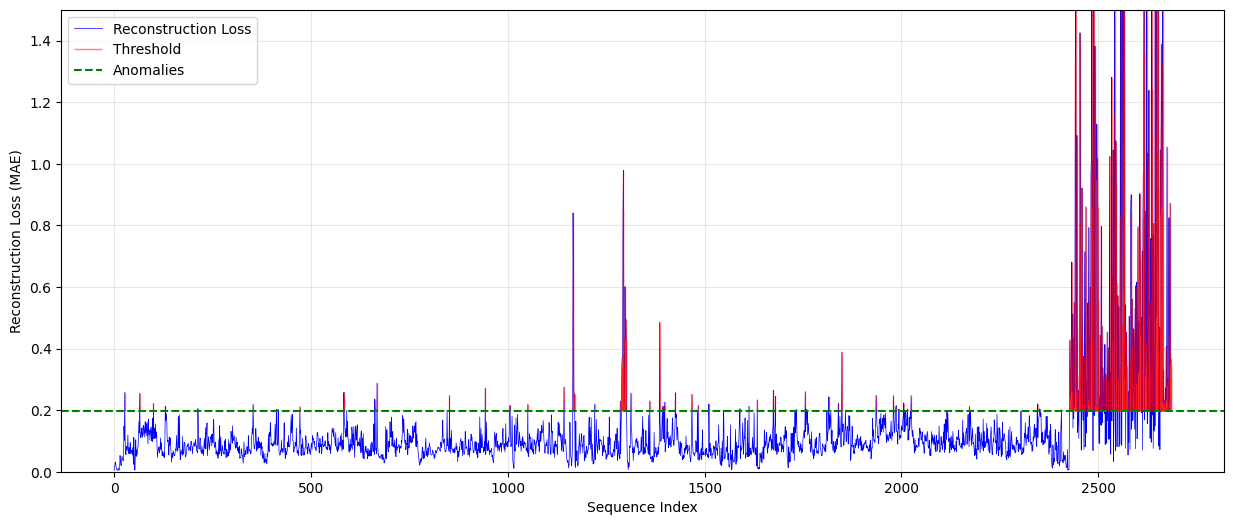

In [8]:
# Combine normal and abnormal data
all_test_data = np.vstack([test_data_scaled_normal, test_data_scaled_abnormal])
all_reconstructions = lstm.predict(all_test_data)
reconstruction_loss = tf.keras.losses.mae(all_reconstructions, all_test_data)
reconstruction_loss_np = reconstruction_loss.numpy().mean(axis=1)

# Find anomaly indices
anomaly_indices = np.where(reconstruction_loss_np > loaded_thresholds['low_threshold'])[0]

# Create the plot
plt.figure(figsize=(15, 6))

# Plot reconstruction loss
plt.plot(range(len(reconstruction_loss_np)), reconstruction_loss_np, 'b-', linewidth=0.5, label='Reconstruction Loss')

# Plot anomalies directly
plt.vlines(x=anomaly_indices, 
          ymin=loaded_thresholds['low_threshold'], 
          ymax=reconstruction_loss_np[anomaly_indices],
          color='red',
          linewidth=1,
          alpha=0.5)

# Add threshold line
plt.axhline(y=loaded_thresholds['low_threshold'], color='green', linestyle='--', label='Threshold')

# Customize the plot
plt.xlabel('Sequence Index', fontsize=10)
plt.ylabel('Reconstruction Loss (MAE)', fontsize=10)
plt.ylim(0, 1.5)  # Adjusted y-axis limit for better visibility
plt.grid(True, alpha=0.3)
plt.legend(['Reconstruction Loss', 'Threshold', 'Anomalies'])

# Show the plot
plt.show()
